In [1]:
using Random
using StatsBase
using Distributions
using StatsPlots
using StatsFuns

using Turing
using CSV
using DataFrames
using Optim

## 1 Good King Markov and His Island Kingdom

In [2]:
Random.seed!(1)
num_weeks = 10^5
positions = []
current = 10

for i ∈ 1:num_weeks
    
    # record current position
    push!(positions, current)
    
    # flip coin to generate proposal
    proposal = current + sample([-1, 1])
    
    # handle loops around
    proposal < 1 && (proposal = 10)
    proposal > 10 && (proposal = 1)
    
    # move?
    prob_move = proposal / current
    if (rand() < prob_move) current = proposal end
    
end

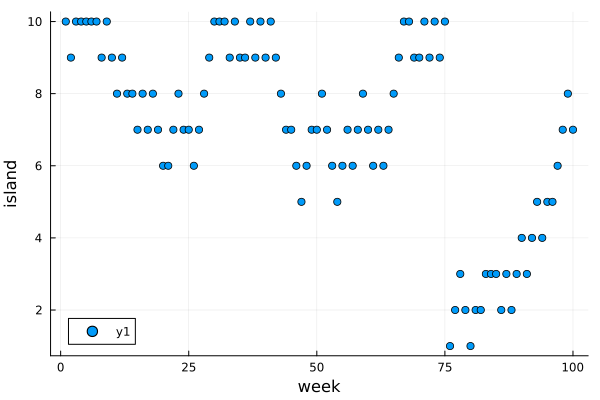

In [3]:
scatter(positions[1:100], xlab="week", ylab="island")

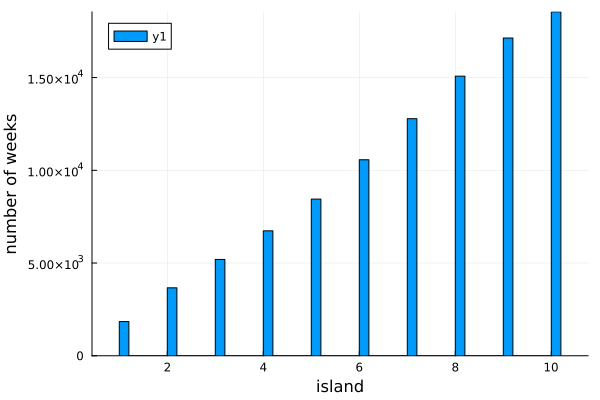

In [5]:
histogram(positions, xlab="island", ylab="number of weeks")

## 2 Metropolis algorithms

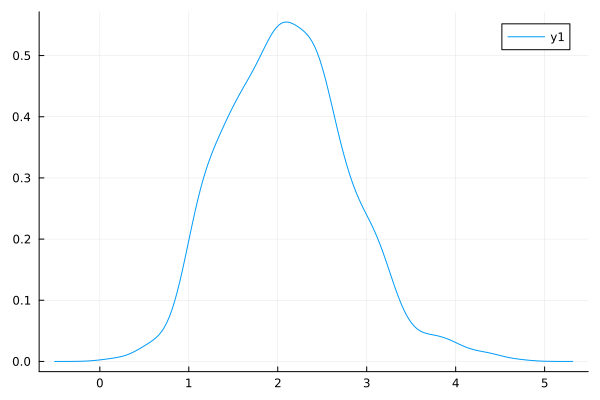

In [6]:
D = 5
T = 1000
Y = rand(MvNormal(zeros(D), ones(D)), T)
Rd = sqrt.(sum.(eachcol(Y.^2)))
density(Rd)
# As the dimension (D) increases, we end up sampling further and further away from the peak in the distribution (Y=0)

## 3 Hamiltonian Monte Carlo

In [7]:
# Let's use a simple case of a bivariate normal distribution

Random.seed!(7)

x = rand(Normal(), 50)
y = rand(Normal(), 50)
x = standardize(ZScoreTransform, x)
y = standardize(ZScoreTransform, y);

In [8]:
function E(z::Vector{Float64}; a=0, b=0.5, k=0, d=0.5)::Float64
    μx, μy = z
    E = sum(normlogpdf.(μx, 1, x)) + sum(normlogpdf.(μy, 1, y)) 
    E += normlogpdf(a, b, μx) + normlogpdf(k, d, μy)
    -E
end

function ∇E(z::Vector{Float64}; a=0, b=0.5, k=0, d=0.5)::Vector{Float64}
    μx, μy = z
    G₁ = sum(x .- μx) / 1^2 + (a - μx) / b^2  # ∂U/∂μx
    G₂ = sum(y .- μy) / 1^2 + (k - μy) / d^2  # ∂U/∂μy
    [-G₁, -G₂]
end


function HMC2(E, ∇E, ϵ::Float64, L::Int, current_z::Vector{Float64})

    z = current_z
    r = rand(Normal(), length(z))  # random flick - p is momentum
    current_r = r
    
    # make a half step for momentum at the beginning
    r -= ϵ * ∇E(z) / 2
    
    # initialize bookkeeping - saves trajectory
    ztraj = [z]
    rtraj = [r]
    
    # Alternate full steps for position and momentum
    for i ∈ 1:L
        z = z .+ ϵ * r  # full step for the position
        # make a full step for the momentum except at the end of trajectory
        if i != L
            r -= ϵ * ∇E(z)
            push!(rtraj, r)
        end
        push!(ztraj, z)
    end
    
    # Make a half step for momentum at the end
    r -= ϵ * ∇E(z) / 2
    push!(rtraj, r)
    
    # negate momentum at the end of trajectory to make the proposal symmetric
    r = -r
    
    # evaluate potential and kinetic energies at the start and the end of trajectory
    current_E = E(current_z)
    current_K = sum(current_r.^2)/2
    proposed_E = E(z)
    proposed_K = sum(r.^2)/2
    
    # accept or reject the state at the end of trajectory 
    # based in part on whether the total energy conservation is valid,
    # returning either the position at the end of the trajectory or the initial position
    accept = (rand() < exp(current_E + current_K - proposed_E - proposed_K))

    if accept
        current_z = z
    end
    
    (z=current_z, traj=ztraj, rtraj=rtraj, accept=accept)

end

HMC2 (generic function with 1 method)

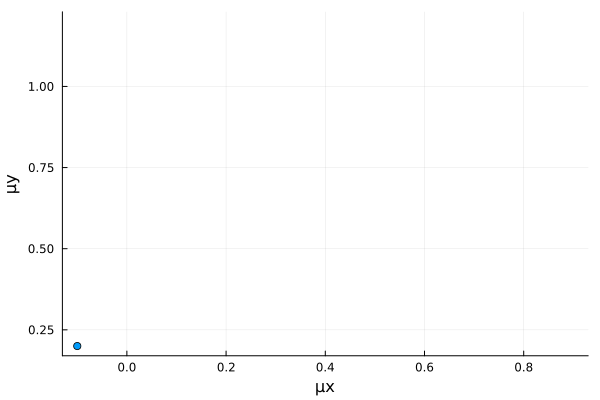

In [9]:
Random.seed!(1)
Q = (z=[-0.1, 0.2],)  # initialize Q.z.  Note that Q serves as a output "container" and is an array of named tuples generated from HMC2

step = 0.03
L = 11

n_samples = 4

plot_mu = scatter([Q.z[1]], [Q.z[2]], xlab="μx", ylab="μy", label = false)


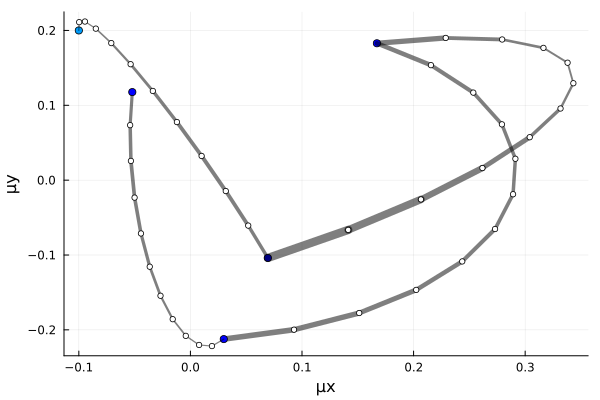

In [10]:

for i ∈ 1:n_samples
    Q = HMC2(E, ∇E, step, L, Q.z)
    if n_samples < 10 
        cx, cy = [], []
        for j ∈ 1:L
            K0 = sum(Q.rtraj[j].^2)/2  # kinetic energy
            plot!(
                [Q.traj[j][1], Q.traj[j+1][1]],
                [Q.traj[j][2], Q.traj[j+1][2]],
                lw=1+2*K0,  # line width is proportional to kinetic energy
                c=:black,
                alpha=0.5,
                label=false
            )
            push!(cx, Q.traj[j+1][1])
            push!(cy, Q.traj[j+1][2])
        end
        scatter!(cx, cy, c=:white, ms=3, label = false)
    end
    scatter!([Q.z[1]], [Q.z[2]], shape=(Q.accept ? :circle : :rect), c=:blue, label = false)
end
plot_mu